In [71]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [72]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [73]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [74]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [75]:
tf.keras.backend.clear_session()

In [76]:
subject = 'Rio Grande Do Sul - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [77]:
data = pd.read_csv('2003_mo_model_input_RS.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande Do Sul - Consumo de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - value,Rio Grande do Sul - IDH
0,2003-1,8.192273,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,135.543840,188.093,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.399576,0.775641
1,2003-2,8.186359,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,134.468148,170.973,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.398811,0.775686
2,2003-3,8.180446,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,134.242963,174.880,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.397898,0.775731
3,2003-4,8.174533,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,133.169391,178.111,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.397042,0.775775
4,2003-5,8.168619,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,132.046874,184.331,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.396050,0.775820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.034199,288.217,NaN,NaN,NaN,NaN,0.832392,NaN
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.001080,272.178,NaN,NaN,NaN,NaN,0.829742,NaN
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.052788,272.665,NaN,NaN,NaN,NaN,0.826925,NaN
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.665535,275.972,NaN,NaN,NaN,NaN,0.823550,NaN


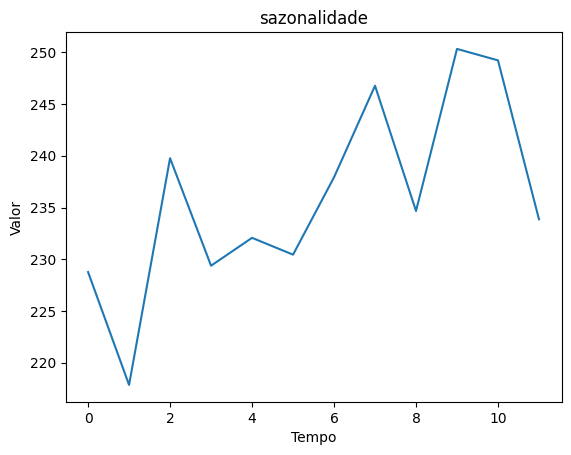

,sazonalidade
sazonalidade,
0,228.76585
1,217.86125
2,239.76200
3,229.37750
4,232.07110
5,230.44500
6,237.91630
7,246.76405
8,234.66495


In [78]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [79]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - value,Rio Grande do Sul - IDH,sazonalidade,Rio Grande Do Sul - Consumo de Cimento (t)
0,2003-1,8.192273,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,135.543840,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.399576,0.775641,228.76585,188.093
1,2003-2,8.186359,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,134.468148,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.398811,0.775686,217.86125,170.973
2,2003-3,8.180446,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,134.242963,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.397898,0.775731,239.76200,174.880
3,2003-4,8.174533,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,133.169391,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.397042,0.775775,229.37750,178.111
4,2003-5,8.168619,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,132.046874,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.396050,0.775820,232.07110,184.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.034199,NaN,NaN,NaN,NaN,0.832392,NaN,246.76405,288.217
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.001080,NaN,NaN,NaN,NaN,0.829742,NaN,234.66495,272.178
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.052788,NaN,NaN,NaN,NaN,0.826925,NaN,250.31965,272.665
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.665535,NaN,NaN,NaN,NaN,0.823550,NaN,249.21435,275.972


In [80]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      168.412
1      153.593
2      166.196
3      150.226
4      154.220
        ...   
235        NaN
236        NaN
237        NaN
238        NaN
239        NaN
Name: Rio Grande Do Sul - Consumo de Cimento (t), Length: 240, dtype: float64

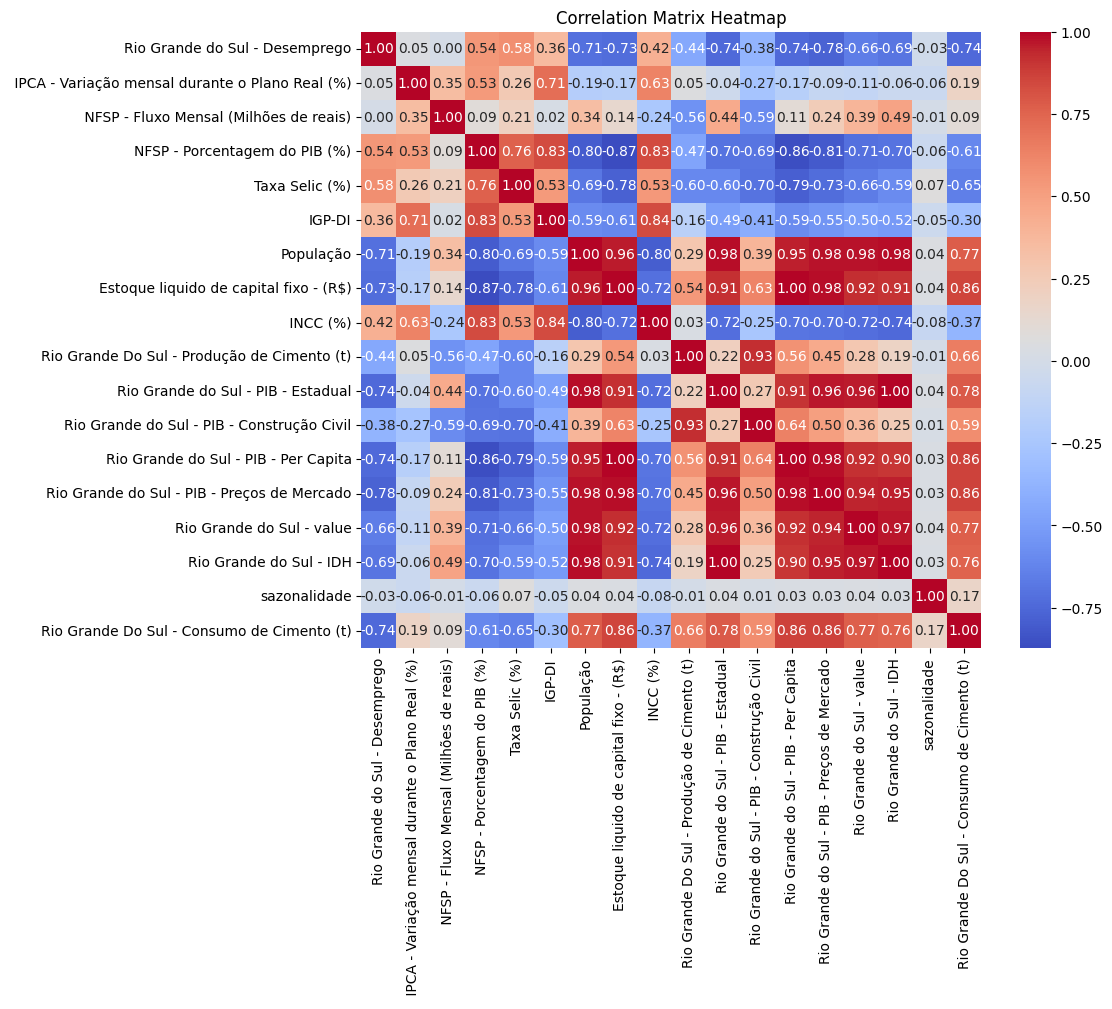

In [81]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [82]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [83]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rio Grande do Sul - Desemprego,4.470387e+03
1,IPCA - Variação mensal durante o Plano Real (%),1.857671e+03
2,NFSP - Fluxo Mensal (Milhões de reais),2.950600e+02
3,NFSP - Porcentagem do PIB (%),5.132329e+02
4,Taxa Selic (%),5.903025e+01
5,IGP-DI,3.931903e+02
6,População,1.176785e+07
7,Estoque liquido de capital fixo - (R$),9.296356e+06
8,INCC (%),1.474886e+03
9,Rio Grande Do Sul - Produção de Cimento (t),5.284137e+04


In [84]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 1


,Rio Grande do Sul - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - value,Rio Grande do Sul - IDH,sazonalidade
0,8.192273,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,135.543840,2.066295e+08,8.907130e+06,1.960625e+08,0.399576,0.775641,228.76585
1,8.186359,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,134.468148,2.068579e+08,8.912326e+06,1.961183e+08,0.398811,0.775686,217.86125
2,8.180446,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,134.242963,2.070864e+08,8.917522e+06,1.961742e+08,0.397898,0.775731,239.76200
3,8.174533,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,133.169391,2.073148e+08,8.922718e+06,1.962300e+08,0.397042,0.775775,229.37750
4,8.168619,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,132.046874,2.075433e+08,8.927915e+06,1.962858e+08,0.396050,0.775820,232.07110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,7.357941,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,120.961794,2.453976e+08,9.056092e+06,2.024605e+08,0.620748,0.784007,246.76405
176,7.351327,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,120.032501,2.453529e+08,9.056354e+06,2.024395e+08,0.623172,0.783942,234.66495
177,7.344712,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,119.460653,2.453082e+08,9.056615e+06,2.024184e+08,0.625644,0.783877,250.31965
178,7.338098,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,119.176426,2.452636e+08,9.056877e+06,2.023973e+08,0.627548,0.783812,249.21435


In [85]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - value,Rio Grande do Sul - IDH
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-0.700003,-1.619819,-2.002585,-1.989928,-1.332013,-1.623111
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-0.753907,-1.602762,-1.963247,-1.965567,-1.341690,-1.607978
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-0.765191,-1.585705,-1.923910,-1.941206,-1.353257,-1.592845
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-0.818989,-1.568647,-1.884572,-1.916844,-1.364083,-1.577712
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-0.875240,-1.551590,-1.845234,-1.892483,-1.376647,-1.562580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,-1.430729,1.274758,-0.874861,0.801177,1.467328,1.207477
176,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,-1.477297,1.271422,-0.872881,0.791980,1.498008,1.185584
177,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,-1.505953,1.268086,-0.870900,0.782783,1.529286,1.163691
178,-1.597335,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,-1.520196,1.264750,-0.868920,0.773586,1.553383,1.141799


In [86]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - value,Rio Grande do Sul - IDH
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-0.700003,-1.619819,-2.002585,-1.989928,-1.332013,-1.623111
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-0.753907,-1.602762,-1.963247,-1.965567,-1.341690,-1.607978
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-0.765191,-1.585705,-1.923910,-1.941206,-1.353257,-1.592845
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-0.818989,-1.568647,-1.884572,-1.916844,-1.364083,-1.577712
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-0.875240,-1.551590,-1.845234,-1.892483,-1.376647,-1.562580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-0.960452,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,-1.078701,1.291642,-0.751413,0.902653,1.140559,1.414074
164,-1.007966,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,-1.126937,1.292936,-0.778876,0.895233,1.160875,1.403405
165,-0.976556,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,-1.157695,1.294229,-0.806338,0.887814,1.191801,1.392735
166,-1.146834,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,-1.181601,1.295522,-0.833800,0.880395,1.217959,1.382066


In [87]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      168.412
1      153.593
2      166.196
3      150.226
4      154.220
        ...   
163    244.406
164    201.372
165    251.369
166    242.782
167    201.288
Name: Rio Grande Do Sul - Consumo de Cimento (t), Length: 168, dtype: float64

In [88]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [89]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 14)

In [90]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - value,Rio Grande do Sul - IDH
132,1.530065,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,0.537273,1.034498,0.217214,1.075727,0.920926,1.033545
133,1.649361,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,0.483618,1.047636,0.179486,1.072662,0.944084,1.044102
134,1.622916,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,0.434802,1.060774,0.141759,1.069598,0.962166,1.054658
135,1.581460,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,0.385040,1.073912,0.104031,1.066533,0.980232,1.065214
136,1.638292,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,0.334744,1.087050,0.066304,1.063469,1.000912,1.075770
137,1.643773,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,0.283743,1.100188,0.028577,1.060404,1.019037,1.086327
138,1.704584,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,0.232581,1.113327,-0.009151,1.057340,1.024007,1.096883
139,1.841703,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,0.181174,1.126465,-0.046878,1.054276,1.031093,1.107439
140,1.837218,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,0.129412,1.139603,-0.084606,1.051211,1.037745,1.117996
141,1.797860,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,0.077551,1.152741,-0.122333,1.048147,1.049164,1.128552


In [91]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 14)

In [92]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [93]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [94]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [95]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3577337834, 1265495728, 3920683433, 4037420457, 2399463437, 1307196947, 750941716, 839439014, 2597877999, 3623774869]


Step: 0 ___________________________________________
val_loss: 511.6350402832031
winner_seed: 3577337834


Step: 1 ___________________________________________
val_loss: 453.42254638671875
winner_seed: 1265495728


Step: 2 ___________________________________________
val_loss: 777.0765380859375


Step: 3 ___________________________________________
val_loss: 6150.8466796875


Step: 4 ___________________________________________
val_loss: 405.88043212890625
winner_seed: 2399463437


Step: 5 ___________________________________________
val_loss: 613.7540893554688


Step: 6 ___________________________________________
val_loss: 704.5244140625


Step: 7 ___________________________________________
val_loss: 495.04656982421875


Step: 8 ___________________________________________
val_loss: 556.2536010742188


Step: 9 ___________________________________________
val_loss: 441.82226

In [96]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 1668180562

Epoch 1/10000
4/4 [==============================] - 2s 137ms/step - loss: 50317.3945 - val_loss: 437.3676
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 1563.0293 - val_loss: 1730.3132
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 1053.2267 - val_loss: 1951.9436
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 1047.2139 - val_loss: 1486.4489
Epoch 5/10000
4/4 [==============================] - 0s 10ms/step - loss: 1096.1100 - val_loss: 2132.3733
Epoch 6/10000
4/4 [==============================] - 0s 10ms/step - loss: 1058.7296 - val_loss: 2262.5295
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 1057.0221 - val_loss: 1875.8304
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 1061.6613 - val_loss: 1227.9535
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 1031.2704 - val_loss: 1647.5709
Epoch 10/10000
4/4 [==============================]

4/4 [==============================] - 0s 9ms/step - loss: 272.0973 - val_loss: 3302.0852
Epoch 80/10000
4/4 [==============================] - 0s 10ms/step - loss: 273.3661 - val_loss: 3327.3433
Epoch 81/10000
4/4 [==============================] - 0s 10ms/step - loss: 265.3265 - val_loss: 3311.9976
Epoch 82/10000
4/4 [==============================] - 0s 9ms/step - loss: 265.4774 - val_loss: 3311.3967
Epoch 83/10000
4/4 [==============================] - 0s 9ms/step - loss: 272.4811 - val_loss: 3321.4983
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 282.6761 - val_loss: 3295.5833
Epoch 85/10000
4/4 [==============================] - 0s 9ms/step - loss: 266.8814 - val_loss: 3317.9292
Epoch 86/10000
4/4 [==============================] - 0s 9ms/step - loss: 258.0703 - val_loss: 3301.9519
Epoch 87/10000
4/4 [==============================] - 0s 9ms/step - loss: 267.6794 - val_loss: 3302.5784
Epoch 88/10000
4/4 [==============================] - 0s 9ms/step - 

4/4 [==============================] - 0s 8ms/step - loss: 261.2062 - val_loss: 3244.4470
Epoch 157/10000
4/4 [==============================] - 0s 8ms/step - loss: 261.7006 - val_loss: 3242.3875
Epoch 158/10000
4/4 [==============================] - 0s 8ms/step - loss: 271.3674 - val_loss: 3246.2786
Epoch 159/10000
4/4 [==============================] - 0s 9ms/step - loss: 260.6397 - val_loss: 3236.3113
Epoch 160/10000
4/4 [==============================] - 0s 8ms/step - loss: 261.1653 - val_loss: 3236.5383
Epoch 161/10000
4/4 [==============================] - 0s 8ms/step - loss: 258.8830 - val_loss: 3233.3738
Epoch 162/10000
4/4 [==============================] - 0s 8ms/step - loss: 254.1834 - val_loss: 3235.8142
Epoch 163/10000
4/4 [==============================] - 0s 8ms/step - loss: 252.9446 - val_loss: 3236.0059
Epoch 164/10000
4/4 [==============================] - 0s 8ms/step - loss: 252.0431 - val_loss: 3236.6233
Epoch 165/10000
4/4 [==============================] - 0s 8ms/

4/4 [==============================] - 0s 9ms/step - loss: 254.6049 - val_loss: 3223.0183
Epoch 234/10000
4/4 [==============================] - 0s 8ms/step - loss: 262.4911 - val_loss: 3233.9778
Epoch 235/10000
4/4 [==============================] - 0s 9ms/step - loss: 264.4239 - val_loss: 3240.1919
Epoch 236/10000
4/4 [==============================] - 0s 8ms/step - loss: 247.1589 - val_loss: 3234.6074
Epoch 237/10000
4/4 [==============================] - 0s 8ms/step - loss: 264.2476 - val_loss: 440.7902
Epoch 238/10000
4/4 [==============================] - 0s 9ms/step - loss: 257.3246 - val_loss: 3230.9084
Epoch 239/10000
4/4 [==============================] - 0s 9ms/step - loss: 247.9481 - val_loss: 447.4556
Epoch 240/10000
4/4 [==============================] - 0s 8ms/step - loss: 267.4304 - val_loss: 445.9186
Epoch 241/10000
4/4 [==============================] - 0s 8ms/step - loss: 254.1177 - val_loss: 443.9351
Epoch 242/10000
4/4 [==============================] - 0s 9ms/step

Epoch 311/10000
4/4 [==============================] - 0s 8ms/step - loss: 258.0567 - val_loss: 448.7982
Epoch 312/10000
4/4 [==============================] - 0s 8ms/step - loss: 245.4089 - val_loss: 443.3177
Epoch 313/10000
4/4 [==============================] - 0s 8ms/step - loss: 247.0921 - val_loss: 446.4875
Epoch 314/10000
4/4 [==============================] - 0s 8ms/step - loss: 250.1072 - val_loss: 445.8261
Epoch 315/10000
4/4 [==============================] - 0s 9ms/step - loss: 265.4185 - val_loss: 440.3614
Epoch 316/10000
4/4 [==============================] - 0s 9ms/step - loss: 254.0438 - val_loss: 442.1877
Epoch 317/10000
4/4 [==============================] - 0s 9ms/step - loss: 243.7323 - val_loss: 442.3745
Epoch 318/10000
4/4 [==============================] - 0s 9ms/step - loss: 254.5529 - val_loss: 442.7240
Epoch 319/10000
4/4 [==============================] - 0s 9ms/step - loss: 246.2862 - val_loss: 442.3372
Epoch 320/10000
4/4 [==============================] - 

Epoch 389/10000
4/4 [==============================] - 0s 8ms/step - loss: 253.3486 - val_loss: 443.3098
Epoch 390/10000
4/4 [==============================] - 0s 9ms/step - loss: 278.8271 - val_loss: 441.6235
Epoch 391/10000
4/4 [==============================] - 0s 8ms/step - loss: 241.5106 - val_loss: 440.8154
Epoch 392/10000
4/4 [==============================] - 0s 9ms/step - loss: 234.3913 - val_loss: 440.8252
Epoch 393/10000
4/4 [==============================] - 0s 8ms/step - loss: 234.9297 - val_loss: 444.5983
Epoch 394/10000
4/4 [==============================] - 0s 8ms/step - loss: 233.9276 - val_loss: 441.2547
Epoch 395/10000
4/4 [==============================] - 0s 8ms/step - loss: 239.0779 - val_loss: 445.1914
Epoch 396/10000
4/4 [==============================] - 0s 8ms/step - loss: 238.1274 - val_loss: 439.2350
Epoch 397/10000
4/4 [==============================] - 0s 8ms/step - loss: 238.1296 - val_loss: 442.3019
Epoch 398/10000
4/4 [==============================] - 

Epoch 467/10000
4/4 [==============================] - 0s 9ms/step - loss: 231.1247 - val_loss: 455.2102
Epoch 468/10000
4/4 [==============================] - 0s 9ms/step - loss: 228.4172 - val_loss: 445.9345
Epoch 469/10000
4/4 [==============================] - 0s 9ms/step - loss: 231.2953 - val_loss: 445.1230
Epoch 470/10000
4/4 [==============================] - 0s 8ms/step - loss: 222.2010 - val_loss: 442.0001
Epoch 471/10000
4/4 [==============================] - 0s 9ms/step - loss: 221.3171 - val_loss: 444.8181
Epoch 472/10000
4/4 [==============================] - 0s 9ms/step - loss: 228.8442 - val_loss: 443.1002
Epoch 473/10000
4/4 [==============================] - 0s 9ms/step - loss: 224.9618 - val_loss: 442.6262
Epoch 474/10000
4/4 [==============================] - 0s 9ms/step - loss: 215.1553 - val_loss: 442.7261
Epoch 475/10000
4/4 [==============================] - 0s 9ms/step - loss: 225.8996 - val_loss: 442.8333
Epoch 476/10000
4/4 [==============================] - 

Epoch 545/10000
4/4 [==============================] - 0s 9ms/step - loss: 202.7322 - val_loss: 470.5102
Epoch 546/10000
4/4 [==============================] - 0s 9ms/step - loss: 196.5429 - val_loss: 448.3990
Epoch 547/10000
4/4 [==============================] - 0s 9ms/step - loss: 209.7538 - val_loss: 443.8668
Epoch 548/10000
4/4 [==============================] - 0s 9ms/step - loss: 190.0991 - val_loss: 440.5674
Epoch 549/10000
4/4 [==============================] - 0s 9ms/step - loss: 199.7879 - val_loss: 445.0340
Epoch 550/10000
4/4 [==============================] - 0s 10ms/step - loss: 213.2844 - val_loss: 452.2640
Epoch 551/10000
4/4 [==============================] - 0s 9ms/step - loss: 214.0708 - val_loss: 447.4387
Epoch 552/10000
4/4 [==============================] - 0s 9ms/step - loss: 186.3833 - val_loss: 444.5690
Epoch 553/10000
4/4 [==============================] - 0s 9ms/step - loss: 218.7302 - val_loss: 436.8327
Epoch 554/10000
4/4 [==============================] -

Epoch 623/10000
4/4 [==============================] - 0s 9ms/step - loss: 173.9967 - val_loss: 438.2468
Epoch 624/10000
4/4 [==============================] - 0s 9ms/step - loss: 175.1167 - val_loss: 436.4975
Epoch 625/10000
4/4 [==============================] - 0s 9ms/step - loss: 176.4456 - val_loss: 440.0908
Epoch 626/10000
4/4 [==============================] - 0s 8ms/step - loss: 188.2529 - val_loss: 437.0383
Epoch 627/10000
4/4 [==============================] - 0s 10ms/step - loss: 197.8334 - val_loss: 446.0531
Epoch 628/10000
4/4 [==============================] - 0s 9ms/step - loss: 174.8296 - val_loss: 442.1150
Epoch 629/10000
4/4 [==============================] - 0s 9ms/step - loss: 173.0266 - val_loss: 445.8120
Epoch 630/10000
4/4 [==============================] - 0s 9ms/step - loss: 176.1325 - val_loss: 447.8839
Epoch 631/10000
4/4 [==============================] - 0s 8ms/step - loss: 185.8459 - val_loss: 440.5529
Epoch 632/10000
4/4 [==============================] -

Epoch 701/10000
4/4 [==============================] - 0s 9ms/step - loss: 170.6371 - val_loss: 487.2616
Epoch 702/10000
4/4 [==============================] - 0s 9ms/step - loss: 182.6851 - val_loss: 474.7956
Epoch 703/10000
4/4 [==============================] - 0s 9ms/step - loss: 176.0023 - val_loss: 447.9367
Epoch 704/10000
4/4 [==============================] - 0s 9ms/step - loss: 164.2709 - val_loss: 446.3651
Epoch 705/10000
4/4 [==============================] - 0s 9ms/step - loss: 167.0482 - val_loss: 452.5616
Epoch 706/10000
4/4 [==============================] - 0s 9ms/step - loss: 164.4064 - val_loss: 450.0355
Epoch 707/10000
4/4 [==============================] - 0s 9ms/step - loss: 166.6300 - val_loss: 450.4179
Epoch 708/10000
4/4 [==============================] - 0s 9ms/step - loss: 159.5074 - val_loss: 446.4349
Epoch 709/10000
4/4 [==============================] - 0s 9ms/step - loss: 160.6731 - val_loss: 449.5208
Epoch 710/10000
4/4 [==============================] - 

Epoch 779/10000
4/4 [==============================] - 0s 8ms/step - loss: 157.9430 - val_loss: 449.5285
Epoch 780/10000
4/4 [==============================] - 0s 8ms/step - loss: 155.8573 - val_loss: 448.5247
Epoch 781/10000
4/4 [==============================] - 0s 8ms/step - loss: 171.2743 - val_loss: 486.9685
Epoch 782/10000
4/4 [==============================] - 0s 9ms/step - loss: 166.8773 - val_loss: 440.6873
Epoch 783/10000
4/4 [==============================] - 0s 10ms/step - loss: 159.0503 - val_loss: 452.0981
Epoch 784/10000
4/4 [==============================] - 0s 8ms/step - loss: 165.2102 - val_loss: 445.9868
Epoch 785/10000
4/4 [==============================] - 0s 7ms/step - loss: 169.2870 - val_loss: 448.4560
Epoch 786/10000
4/4 [==============================] - 0s 7ms/step - loss: 158.1659 - val_loss: 449.5171
Epoch 787/10000
4/4 [==============================] - 0s 7ms/step - loss: 153.4701 - val_loss: 450.9482
Epoch 788/10000
4/4 [==============================] -

4/4 [==============================] - 0s 8ms/step - loss: 166.5266 - val_loss: 474.5319
Epoch 858/10000
4/4 [==============================] - 0s 8ms/step - loss: 161.5691 - val_loss: 476.6424
Epoch 859/10000
4/4 [==============================] - 0s 8ms/step - loss: 183.8922 - val_loss: 470.4243
Epoch 860/10000
4/4 [==============================] - 0s 8ms/step - loss: 177.4263 - val_loss: 459.6633
Epoch 861/10000
4/4 [==============================] - 0s 8ms/step - loss: 166.2022 - val_loss: 458.6803
Epoch 862/10000
4/4 [==============================] - 0s 9ms/step - loss: 169.3904 - val_loss: 471.4466
Epoch 863/10000
4/4 [==============================] - 0s 10ms/step - loss: 173.2674 - val_loss: 466.8872
Epoch 864/10000
4/4 [==============================] - 0s 9ms/step - loss: 165.2838 - val_loss: 457.9206
Epoch 865/10000
4/4 [==============================] - 0s 8ms/step - loss: 174.4096 - val_loss: 457.7446
Epoch 866/10000
4/4 [==============================] - 0s 7ms/step - l

4/4 [==============================] - 0s 8ms/step - loss: 153.6287 - val_loss: 588.0572
Epoch 936/10000
4/4 [==============================] - 0s 8ms/step - loss: 163.6292 - val_loss: 692.6179
Epoch 937/10000
4/4 [==============================] - 0s 8ms/step - loss: 162.8430 - val_loss: 633.8394
Epoch 938/10000
4/4 [==============================] - 0s 8ms/step - loss: 194.0807 - val_loss: 631.0048
Epoch 939/10000
4/4 [==============================] - 0s 8ms/step - loss: 178.9276 - val_loss: 636.7303
Epoch 940/10000
4/4 [==============================] - 0s 8ms/step - loss: 160.2870 - val_loss: 687.5103
Epoch 941/10000
4/4 [==============================] - 0s 9ms/step - loss: 174.7863 - val_loss: 607.1747
Epoch 942/10000
4/4 [==============================] - 0s 8ms/step - loss: 163.8430 - val_loss: 621.3267
Epoch 943/10000
4/4 [==============================] - 0s 8ms/step - loss: 163.7137 - val_loss: 659.4466
Epoch 944/10000
4/4 [==============================] - 0s 8ms/step - lo

4/4 [==============================] - 0s 8ms/step - loss: 150.5379 - val_loss: 507.9427
Epoch 1014/10000
4/4 [==============================] - 0s 8ms/step - loss: 158.9165 - val_loss: 514.3691
Epoch 1015/10000
4/4 [==============================] - 0s 8ms/step - loss: 149.1517 - val_loss: 541.6318
Epoch 1016/10000
4/4 [==============================] - 0s 9ms/step - loss: 149.3015 - val_loss: 493.6574
Epoch 1017/10000
4/4 [==============================] - 0s 9ms/step - loss: 150.8094 - val_loss: 536.8142
Epoch 1018/10000
4/4 [==============================] - 0s 8ms/step - loss: 168.6739 - val_loss: 526.7761
Epoch 1019/10000
4/4 [==============================] - 0s 8ms/step - loss: 156.6421 - val_loss: 468.2033
Epoch 1020/10000
4/4 [==============================] - 0s 9ms/step - loss: 153.8436 - val_loss: 530.1877
Epoch 1021/10000
4/4 [==============================] - 0s 10ms/step - loss: 163.0695 - val_loss: 451.8953
Epoch 1022/10000
4/4 [==============================] - 0s 9ms

4/4 [==============================] - 0s 8ms/step - loss: 145.5333 - val_loss: 510.5514
Epoch 1091/10000
4/4 [==============================] - 0s 9ms/step - loss: 153.4755 - val_loss: 530.4607
Epoch 1092/10000
4/4 [==============================] - 0s 8ms/step - loss: 149.3426 - val_loss: 482.2069
Epoch 1093/10000
4/4 [==============================] - 0s 9ms/step - loss: 139.2767 - val_loss: 506.7564
Epoch 1094/10000
4/4 [==============================] - 0s 8ms/step - loss: 143.0805 - val_loss: 503.1410
Epoch 1095/10000
4/4 [==============================] - 0s 8ms/step - loss: 147.5865 - val_loss: 507.2917
Epoch 1096/10000
4/4 [==============================] - 0s 9ms/step - loss: 154.4626 - val_loss: 487.5637
Epoch 1097/10000
4/4 [==============================] - 0s 8ms/step - loss: 154.7188 - val_loss: 521.1406
Epoch 1098/10000
4/4 [==============================] - 0s 9ms/step - loss: 151.9989 - val_loss: 484.5832
Epoch 1099/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 9ms/step - loss: 136.4227 - val_loss: 487.7455
Epoch 1168/10000
4/4 [==============================] - 0s 8ms/step - loss: 150.0766 - val_loss: 547.3608
Epoch 1169/10000
4/4 [==============================] - 0s 8ms/step - loss: 143.5055 - val_loss: 480.2589
Epoch 1170/10000
4/4 [==============================] - 0s 8ms/step - loss: 138.1269 - val_loss: 541.8286
Epoch 1171/10000
4/4 [==============================] - 0s 8ms/step - loss: 148.7516 - val_loss: 538.8024
Epoch 1172/10000
4/4 [==============================] - 0s 9ms/step - loss: 140.7512 - val_loss: 495.1133
Epoch 1173/10000
4/4 [==============================] - 0s 8ms/step - loss: 142.5354 - val_loss: 483.8675
Epoch 1174/10000
4/4 [==============================] - 0s 9ms/step - loss: 138.7910 - val_loss: 499.0582
Epoch 1175/10000
4/4 [==============================] - 0s 8ms/step - loss: 139.1096 - val_loss: 477.5691
Epoch 1176/10000
4/4 [==============================] - 0s 9ms/

4/4 [==============================] - 0s 8ms/step - loss: 132.4268 - val_loss: 458.0278
Epoch 1245/10000
4/4 [==============================] - 0s 8ms/step - loss: 135.3218 - val_loss: 465.4442
Epoch 1246/10000
4/4 [==============================] - 0s 8ms/step - loss: 129.6499 - val_loss: 477.4213
Epoch 1247/10000
4/4 [==============================] - 0s 8ms/step - loss: 133.8870 - val_loss: 473.0663
Epoch 1248/10000
4/4 [==============================] - 0s 8ms/step - loss: 137.9073 - val_loss: 467.9573
Epoch 1249/10000
4/4 [==============================] - 0s 8ms/step - loss: 144.1882 - val_loss: 495.2109
Epoch 1250/10000
4/4 [==============================] - 0s 9ms/step - loss: 135.7404 - val_loss: 492.3861
Epoch 1251/10000
4/4 [==============================] - 0s 8ms/step - loss: 137.6171 - val_loss: 503.8583
Epoch 1252/10000
4/4 [==============================] - 0s 8ms/step - loss: 147.0500 - val_loss: 542.1813
Epoch 1253/10000
4/4 [==============================] - 0s 8ms/

4/4 [==============================] - 0s 9ms/step - loss: 132.1322 - val_loss: 510.7438
Epoch 1322/10000
4/4 [==============================] - 0s 10ms/step - loss: 130.2658 - val_loss: 479.2899
Epoch 1323/10000
4/4 [==============================] - 0s 9ms/step - loss: 127.1182 - val_loss: 451.3871
Epoch 1324/10000
4/4 [==============================] - 0s 9ms/step - loss: 127.9541 - val_loss: 443.2641
Epoch 1325/10000
4/4 [==============================] - 0s 9ms/step - loss: 134.3274 - val_loss: 418.8282
Epoch 1326/10000
4/4 [==============================] - 0s 8ms/step - loss: 125.7465 - val_loss: 474.2847
Epoch 1327/10000
4/4 [==============================] - 0s 8ms/step - loss: 121.7417 - val_loss: 457.0343
Epoch 1328/10000
4/4 [==============================] - 0s 9ms/step - loss: 123.2137 - val_loss: 451.1301
Epoch 1329/10000
4/4 [==============================] - 0s 8ms/step - loss: 127.3240 - val_loss: 467.3732
Epoch 1330/10000
4/4 [==============================] - 0s 8ms

4/4 [==============================] - 0s 9ms/step - loss: 113.0238 - val_loss: 466.8117
Epoch 1399/10000
4/4 [==============================] - 0s 8ms/step - loss: 111.0063 - val_loss: 440.2955
Epoch 1400/10000
4/4 [==============================] - 0s 9ms/step - loss: 118.9753 - val_loss: 512.0717
Epoch 1401/10000
4/4 [==============================] - 0s 9ms/step - loss: 123.3941 - val_loss: 513.3431
Epoch 1402/10000
4/4 [==============================] - 0s 9ms/step - loss: 195.8442 - val_loss: 658.3332
Epoch 1403/10000
4/4 [==============================] - 0s 8ms/step - loss: 189.4981 - val_loss: 604.5308
Epoch 1404/10000
4/4 [==============================] - 0s 9ms/step - loss: 128.4294 - val_loss: 522.2988
Epoch 1405/10000
4/4 [==============================] - 0s 9ms/step - loss: 144.7613 - val_loss: 495.2817
Epoch 1406/10000
4/4 [==============================] - 0s 9ms/step - loss: 135.5282 - val_loss: 541.9501
Epoch 1407/10000
4/4 [==============================] - 0s 8ms/

4/4 [==============================] - 0s 10ms/step - loss: 111.8786 - val_loss: 575.0325
Epoch 1476/10000
4/4 [==============================] - 0s 9ms/step - loss: 115.4571 - val_loss: 686.0936
Epoch 1477/10000
4/4 [==============================] - 0s 8ms/step - loss: 134.8992 - val_loss: 655.0289
Epoch 1478/10000
4/4 [==============================] - 0s 8ms/step - loss: 136.0131 - val_loss: 542.8668
Epoch 1479/10000
4/4 [==============================] - 0s 9ms/step - loss: 108.4481 - val_loss: 586.9753
Epoch 1480/10000
4/4 [==============================] - 0s 8ms/step - loss: 109.9966 - val_loss: 576.1562
Epoch 1481/10000
4/4 [==============================] - 0s 8ms/step - loss: 95.0146 - val_loss: 482.2616
Epoch 1482/10000
4/4 [==============================] - 0s 8ms/step - loss: 102.3115 - val_loss: 498.2867
Epoch 1483/10000
4/4 [==============================] - 0s 9ms/step - loss: 103.4609 - val_loss: 734.1158
Epoch 1484/10000
4/4 [==============================] - 0s 8ms/

4/4 [==============================] - 0s 9ms/step - loss: 105.9920 - val_loss: 516.2510
Epoch 1553/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.3676 - val_loss: 524.0308
Epoch 1554/10000
4/4 [==============================] - 0s 9ms/step - loss: 99.1140 - val_loss: 588.7072
Epoch 1555/10000
4/4 [==============================] - 0s 9ms/step - loss: 105.4888 - val_loss: 539.2388
Epoch 1556/10000
4/4 [==============================] - 0s 9ms/step - loss: 93.9099 - val_loss: 516.7978
Epoch 1557/10000
4/4 [==============================] - 0s 9ms/step - loss: 100.5627 - val_loss: 548.3110
Epoch 1558/10000
4/4 [==============================] - 0s 9ms/step - loss: 123.0701 - val_loss: 620.8251
Epoch 1559/10000
4/4 [==============================] - 0s 8ms/step - loss: 80.0560 - val_loss: 557.6921
Epoch 1560/10000
4/4 [==============================] - 0s 8ms/step - loss: 94.1559 - val_loss: 551.2285
Epoch 1561/10000
4/4 [==============================] - 0s 8ms/step

4/4 [==============================] - 0s 8ms/step - loss: 158.6667 - val_loss: 586.0366
Epoch 1630/10000
4/4 [==============================] - 0s 8ms/step - loss: 136.0156 - val_loss: 542.5494
Epoch 1631/10000
4/4 [==============================] - 0s 9ms/step - loss: 97.5106 - val_loss: 493.2549
Epoch 1632/10000
4/4 [==============================] - 0s 8ms/step - loss: 98.8665 - val_loss: 552.5436
Epoch 1633/10000
4/4 [==============================] - 0s 9ms/step - loss: 81.6593 - val_loss: 495.0290
Epoch 1634/10000
4/4 [==============================] - 0s 10ms/step - loss: 84.4268 - val_loss: 513.8400
Epoch 1635/10000
4/4 [==============================] - 0s 10ms/step - loss: 103.3628 - val_loss: 567.9878
Epoch 1636/10000
4/4 [==============================] - 0s 9ms/step - loss: 90.8596 - val_loss: 561.6311
Epoch 1637/10000
4/4 [==============================] - 0s 9ms/step - loss: 94.5144 - val_loss: 580.6301
Epoch 1638/10000
4/4 [==============================] - 0s 9ms/step

4/4 [==============================] - 0s 9ms/step - loss: 69.3067 - val_loss: 468.4290
Epoch 1708/10000
4/4 [==============================] - 0s 10ms/step - loss: 69.6355 - val_loss: 475.5164
Epoch 1709/10000
4/4 [==============================] - 0s 9ms/step - loss: 70.6805 - val_loss: 473.1411
Epoch 1710/10000
4/4 [==============================] - 0s 9ms/step - loss: 63.6436 - val_loss: 511.4156
Epoch 1711/10000
4/4 [==============================] - 0s 10ms/step - loss: 60.9705 - val_loss: 460.8943
Epoch 1712/10000
4/4 [==============================] - 0s 9ms/step - loss: 64.8072 - val_loss: 539.7621
Epoch 1713/10000
4/4 [==============================] - 0s 9ms/step - loss: 63.4324 - val_loss: 455.3763
Epoch 1714/10000
4/4 [==============================] - 0s 9ms/step - loss: 60.6934 - val_loss: 479.5753
Epoch 1715/10000
4/4 [==============================] - 0s 9ms/step - loss: 81.1841 - val_loss: 469.1471
Epoch 1716/10000
4/4 [==============================] - 0s 8ms/step - 

4/4 [==============================] - 0s 8ms/step - loss: 35744982761472.0000 - val_loss: 35726204862464.0000
Epoch 1777/10000
4/4 [==============================] - 0s 8ms/step - loss: 35716398579712.0000 - val_loss: 35697633263616.0000
Epoch 1778/10000
4/4 [==============================] - 0s 8ms/step - loss: 35687835369472.0000 - val_loss: 35669086830592.0000
Epoch 1779/10000
4/4 [==============================] - 0s 8ms/step - loss: 35659293130752.0000 - val_loss: 35640557174784.0000
Epoch 1780/10000
4/4 [==============================] - 0s 9ms/step - loss: 35630776057856.0000 - val_loss: 35612056879104.0000
Epoch 1781/10000
4/4 [==============================] - 0s 9ms/step - loss: 35602284150784.0000 - val_loss: 35583581749248.0000
Epoch 1782/10000
4/4 [==============================] - 0s 8ms/step - loss: 35573809020928.0000 - val_loss: 35555127590912.0000
Epoch 1783/10000
4/4 [==============================] - 0s 9ms/step - loss: 35545359056896.0000 - val_loss: 3552669020979

In [97]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [98]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,225.152054,234.840317,238.273148,238.135452,239.448105,238.714264,236.223251,231.090836,236.806183,239.746719,239.756882,235.567795
Target,226.547,228.5,223.896,234.132,207.586,228.583,234.565,249.519,230.086,233.136,233.8,223.214
Error,1.394943,6.340317,14.377151,4.003448,31.862106,10.131271,1.658249,18.428162,6.720184,6.610718,5.956879,12.35379


In [99]:
display(mae)
display(mape)

9.986435

0.044361588

In [100]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [101]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[2833.7551]] - Target[2753.5640000000003]| =  Error: [[80.19116]]; MAPE:[[0.02912268]]


[array([[80.19116]], dtype=float32)]

80.19116

0.02912268